### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population']

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                   PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.25)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 17:25:11.114 INFO     Building a set of 317255 households from which to build a population
2021-05-16 17:26:07.727 INFO     315950 households of mean size 2.51
2021-05-16 17:26:11.569 INFO     142105 buildings of mean size 5.58
2021-05-16 17:26:44.779 INFO     2079 classrooms of mean size 29.44
2021-05-16 17:26:45.142 INFO     140 care_homes of mean size 104.72
2021-05-16 17:26:46.033 INFO     91798 workplaces of mean size 5.63
2021-05-16 17:26:49.088 INFO     66.0% of workplaces closed by lockdown, leaving 32695 open, of average Income Decile 4.89 (and st dev 3.13).
2021-05-16 17:26:49.251 INFO     66.0% of classrooms closed by lockdown, leaving 713 open, of average Income Decile 4.24 (and st dev 3.03).
2021-05-16 17:26:49.287 INFO     Adding 349498 permanent contact groups
2021-05-16 17:26:49.289 INFO     Adding 0 ephemeral contact pairs
2021-05-16 17:26:50.867 INFO     Adding 239511 contacts each within one of the 142105 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 17:27:26.309 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0178
2021-05-16 17:30:33.424 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0223


### Run the simulation for January and February

2021-05-16 17:31:21.049 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0218
2021-05-16 17:35:33.873 INFO     Day 51, prop infected is 0.20, prop infectious is 0.0032
2021-05-16 17:36:05.866 INFO     Day 60, prop infected is 0.20, prop infectious is 0.0020
2021-05-16 17:36:08.946 INFO      Realized R0 of early infections is 0.96
2021-05-16 17:36:08.947 INFO      20.2 percent of the population was infected during the epidemic


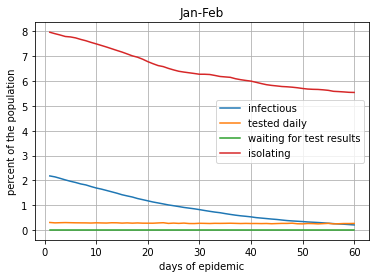

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 17:36:26.361 INFO     66.0% of workplaces closed by lockdown, leaving 33273 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-16 17:36:26.664 INFO     0.0% of classrooms closed by lockdown, leaving 1699 open, of average Income Decile 4.78 (and st dev 3.09).
2021-05-16 17:36:26.705 INFO     Adding 351062 permanent contact groups
2021-05-16 17:36:27.054 INFO     Adding 118971 ephemeral contact pairs
2021-05-16 17:36:28.024 INFO     Adding 239526 contacts each within one of the 142105 buildings (contact density of 0.75)


In [10]:
from codit.society.lateral import LateralFlowUK
lat_flow_soc = LateralFlowUK(config=SOCIETY_CFG)

2021-05-16 17:36:39.058 INFO     The city has 20x the number of lateral flow tests available, as PCRs


2021-05-16 17:37:18.298 INFO     Setting mass testing valency/degree limit to 23
2021-05-16 17:37:26.767 INFO     Day 1, prop infected is 0.20, prop infectious is 0.0019
2021-05-16 17:45:34.469 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0012
2021-05-16 17:45:35.977 INFO      Realized R0 of early infections is 0.99
2021-05-16 17:45:35.978 INFO      20.8 percent of the population was infected during the epidemic


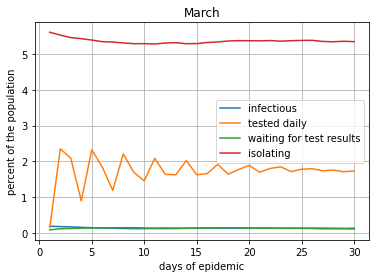

In [11]:
o_March = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

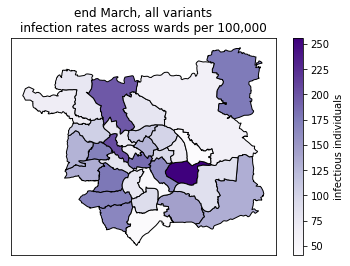

In [12]:
r = o_March.recorder.components[-1]
r.map_incidence(r.infectious, title='end March, all variants', end_date=True, per_hundred_k=True)

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

2021-05-16 17:45:40.173 INFO     50.0% of workplaces closed by lockdown, leaving 48325 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-16 17:45:40.416 INFO     0.0% of classrooms closed by lockdown, leaving 1705 open, of average Income Decile 4.78 (and st dev 3.09).
2021-05-16 17:45:40.459 INFO     Adding 366120 permanent contact groups
2021-05-16 17:45:40.896 INFO     Adding 158628 ephemeral contact pairs
2021-05-16 17:45:41.865 INFO     Adding 239862 contacts each within one of the 142105 buildings (contact density of 0.75)


In [14]:
from codit.population.population import seed_infection

residents = [p for p in pop.people if 'Chapel' in p.home.ward.name]
ca, = {p.home.ward.name for p in residents}
logging.info(f"Seeding 30 infections of the Indian Variant in {ca}")
seed_infection(30, residents, indian_variant)

2021-05-16 17:45:51.734 INFO     Seeding 30 infections of the Indian Variant in Chapel Allerton


In [15]:
for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

In [16]:
pop.clear_memory()

2021-05-16 17:46:49.271 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0012
2021-05-16 17:56:25.023 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0008
2021-05-16 17:56:26.495 INFO      Realized R0 of early infections is 0.95
2021-05-16 17:56:26.496 INFO      21.2 percent of the population was infected during the epidemic


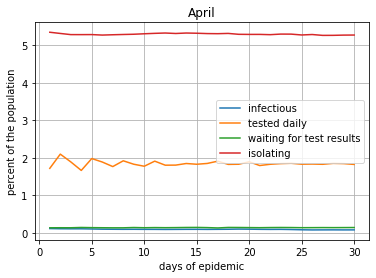

In [17]:
o_April = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

In [18]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

59 cases of the Indian Variant:
2 in Temple Newsam
2 in Farnley & Wortley
5 in Otley & Yeadon
5 in Kirkstall
13 in Gipton & Harehills
5 in Hunslet & Riverside
3 in Little London & Woodhouse
2 in Morley South
1 in Middleton Park
2 in Garforth & Swillington
1 in Killingbeck & Seacroft
3 in Chapel Allerton
3 in Burmantofts & Richmond Hill
1 in Bramley & Stanningley
6 in Guiseley & Rawdon
2 in Cross Gates & Whinmoor
1 in Horsforth
1 in Roundhay
1 in Headingley & Hyde Park


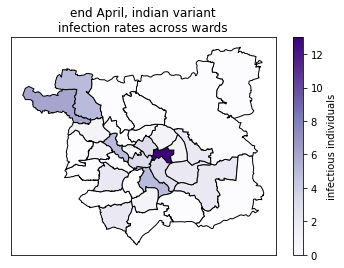

In [19]:
r = o_April.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end April, indian variant', end_date=True)

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [20]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 17:56:47.738 INFO     33.0% of workplaces closed by lockdown, leaving 61560 open, of average Income Decile 4.93 (and st dev 3.13).
2021-05-16 17:56:47.976 INFO     0.0% of classrooms closed by lockdown, leaving 1713 open, of average Income Decile 4.80 (and st dev 3.09).
2021-05-16 17:56:48.023 INFO     Adding 379363 permanent contact groups
2021-05-16 17:56:57.581 INFO     Adding 198285 ephemeral contact pairs
2021-05-16 17:56:58.579 INFO     Adding 239331 contacts each within one of the 142105 buildings (contact density of 0.75)


2021-05-16 17:58:12.256 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0008
2021-05-16 18:13:54.779 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0008
2021-05-16 18:13:57.143 INFO      Realized R0 of early infections is 0.97
2021-05-16 18:13:57.144 INFO      21.5 percent of the population was infected during the epidemic


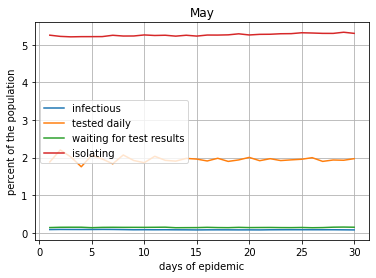

In [21]:
o_May = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")

In [22]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

87 cases of the Indian Variant:
22 in Gipton & Harehills
5 in Adel & Wharfedale
23 in Middleton Park
2 in Chapel Allerton
3 in Beeston & Holbeck
1 in Morley South
1 in Horsforth
2 in Temple Newsam
1 in Calverley & Farsley
1 in Farnley & Wortley
3 in Little London & Woodhouse
2 in Hunslet & Riverside
1 in Morley North
1 in Headingley & Hyde Park
1 in Cross Gates & Whinmoor
7 in Weetwood
2 in Burmantofts & Richmond Hill
1 in Otley & Yeadon
2 in Armley
2 in Moortown
1 in Ardsley & Robin Hood
3 in Garforth & Swillington


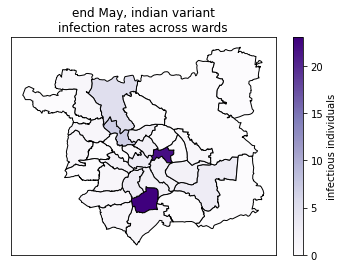

In [23]:
r = o_May.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end May, indian variant', end_date=True)